In [1]:
import torch
import torch.nn as nn
from torch.utils import data
import json
import numpy as np
import random
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import os
import sys
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd

import src.network as network
from src.metrics import StreamSegMetrics
from datasets.kitti_360 import KittiDatasetLoader
from datasets.cityscapes_v1 import CityscapesDatasetLoader



In [2]:

# Defining the model paths
model_name = "deeplabv3plus_resnet101"
old_model_path = 'checkpoints/best_deeplabv3plus_resnet101_cityscapes_os16.pth'
new_model_path = 'checkpoints/ranked_2k_class_SL_full_KD_pixel.pth'


In [3]:
# Load model
def load_model(checkpoint_path, model_name='deeplabv3plus_resnet101', num_classes=19, output_stride=16):
    model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    return model


In [4]:
# Load data
def load_data(json_file, dataset_name, num_test=200):
    if dataset_name == 'cityscapes':
        dataset_loader = CityscapesDatasetLoader()
    elif dataset_name == 'kitti_360':
        dataset_loader = KittiDatasetLoader()
    else:
        raise ValueError(f"Invalid dataset: {dataset_name}")

    with open(json_file, 'r') as file:
        json_data = json.load(file)

    val_image_paths = [item.get('image') for item in json_data if item.get('image_exists')]
    val_ground_truth_paths = [item.get('ground_truth') for item in json_data if item.get('ground_truth_exists')]

    if len(val_image_paths) > num_test:
        sampled_indices = np.random.choice(len(val_image_paths), num_test, replace=False)
        val_image_paths = [val_image_paths[i] for i in sampled_indices]
        val_ground_truth_paths = [val_ground_truth_paths[i] for i in sampled_indices]
        print(f"Sampled {num_test} images from the dataset")

    val_dst = dataset_loader.get_datasets(val_image_paths, val_ground_truth_paths)
    val_loader = data.DataLoader(val_dst, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
    return val_loader, val_image_paths, val_ground_truth_paths


In [5]:
# Validate model
def validate(model, loader, device, metrics):
    metrics.reset()
    scaler = GradScaler()

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            
            with autocast():
                outputs = model(images)
            
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()
            metrics.update(targets, preds)

            # Clear cache to free memory
            del images, labels, outputs
            torch.cuda.empty_cache()
    
    return metrics.get_results()


In [6]:
# # Calculate additional metrics
# def calculate_additional_metrics(metrics, num_classes):
#     precision, recall, f1, _ = precision_recall_fscore_support(metrics.all_targets, metrics.all_preds, average='weighted')
#     cm = confusion_matrix(metrics.all_targets, metrics.all_preds, labels=range(num_classes))
#     return {
#         'Precision': precision,
#         'Recall': recall,
#         'F1-Score': f1,
#         'Confusion Matrix': cm
#     }

def calculate_additional_metrics(metrics, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(metrics.all_targets, metrics.all_preds, average='weighted')
    cm = confusion_matrix(metrics.all_targets, metrics.all_preds, labels=range(num_classes))
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }


In [7]:
def plot_confusion_matrix(cm, class_names, title=None, normalize=True):
    plt.figure(figsize=(12, 10))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    if title:
        plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


In [21]:
def plot_iou_comparison(baseline_iou, finetuned_iou, class_names, dataset_name):
    plt.figure(figsize=(15, 8))
    x = np.arange(len(class_names))
    width = 0.35

    baseline_values = [baseline_iou[i] for i in range(len(class_names))]
    finetuned_values = [finetuned_iou[i] for i in range(len(class_names))]

    plt.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8, color='orange')
    plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned', alpha=0.8, color='blue')

    plt.xlabel('Classes')
    plt.ylabel('IoU')
    plt.title(f'Class-wise IoU Comparison - {dataset_name}')
    plt.xticks(x, class_names, rotation=90)
    plt.legend()

    # Add value labels on top of each bar
    for i, v in enumerate(baseline_values):
        plt.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)
    for i, v in enumerate(finetuned_values):
        plt.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
metrics = StreamSegMetrics(19)


Using device: cuda


In [23]:
# Load models
baseline_model = load_model(old_model_path)
finetuned_model = load_model(new_model_path)


In [24]:
# Load data
datasets = [
    ('cityscapes', 'tests/cityscapes_val_set.json'),
    ('kitti_360', 'tests/kitti-360_val_set_v3.json')
]

class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
    'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
    'motorcycle', 'bicycle'
]


In [26]:
baseline_ious = []
finetuned_ious = []


for dataset_name, json_file in datasets:
    print(f"\nAnalyzing {dataset_name.upper()} dataset:")
    
    # Load data
    val_loader, val_image_paths, val_ground_truth_paths = load_data(json_file, dataset_name, num_test=2000)
    
    # Validate baseline model
    baseline_results = validate(baseline_model, val_loader, device, metrics)
    baseline_iou = [baseline_results['Class IoU'][i] for i in range(len(class_names))]
    baseline_ious.append(baseline_iou)
    # plot_iou_comparison(baseline_iou, finetuned_iou, class_names, dataset_name=dataset_name)

    # Reset metrics for the next model
    metrics.reset()

    # Validate fine-tuned model
    finetuned_results = validate(finetuned_model, val_loader, device, metrics)
    finetuned_iou = [finetuned_results['Class IoU'][i] for i in range(len(class_names))]    
    finetuned_ious.append(finetuned_iou)






Analyzing CITYSCAPES dataset:


100%|██████████| 125/125 [01:47<00:00,  1.16it/s]



Analyzing KITTI_360 dataset:
Sampled 2000 images from the dataset


100%|██████████| 500/500 [01:50<00:00,  4.51it/s]
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:69: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
100%|██████████| 500/500 [01:50<00:00,  4.51it/s]


In [31]:
baseline_ious = np.array(baseline_ious)
finetuned_ious = np.array(finetuned_ious)

print(baseline_ious.shape)
print(finetuned_ious.shape)

(2, 19)
(2, 19)


C:\Users\kbpra\AppData\Local\Temp\ipykernel_28092\3602390608.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


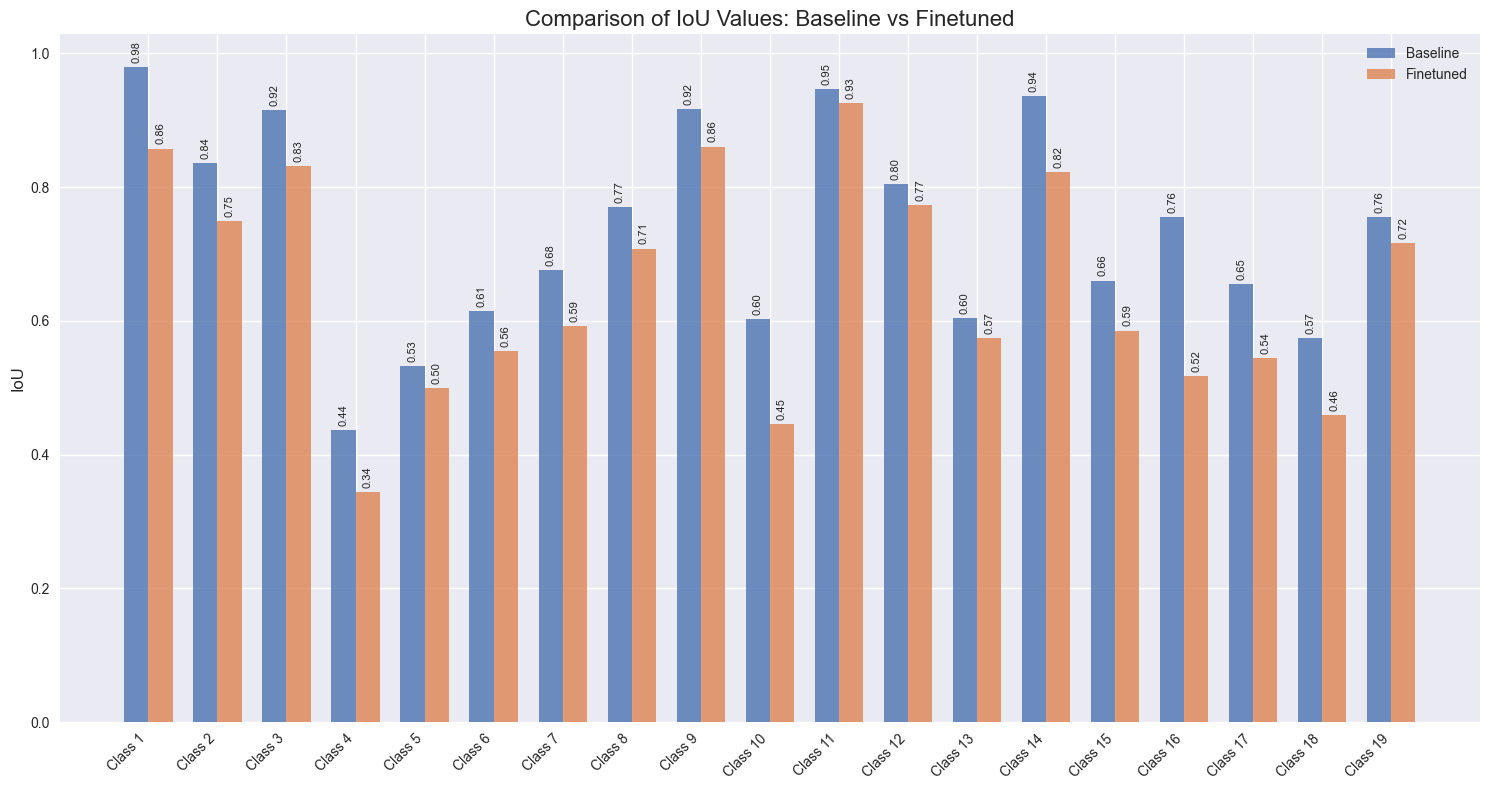

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined baseline_ious and finetuned_ious
# baseline_ious = np.array(baseline_ious)
# finetuned_ious = np.array(finetuned_ious)

# Set up the plot style
plt.style.use('seaborn')
sns.set_palette("deep")

# Create class labels (adjust as needed)
class_labels = [f'Class {i+1}' for i in range(19)]

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(len(class_labels))

# Create the bars
rects1 = ax.bar(x - width/2, baseline_ious[0], width, label='Baseline', alpha=0.8)
rects2 = ax.bar(x + width/2, finetuned_ious[0], width, label='Finetuned', alpha=0.8)

# Customize the plot
ax.set_ylabel('IoU', fontsize=12)
ax.set_title('Comparison of IoU Values: Baseline vs Finetuned', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend(fontsize=10)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=90)

autolabel(rects1)
autolabel(rects2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

C:\Users\kbpra\AppData\Local\Temp\ipykernel_28092\2764777498.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


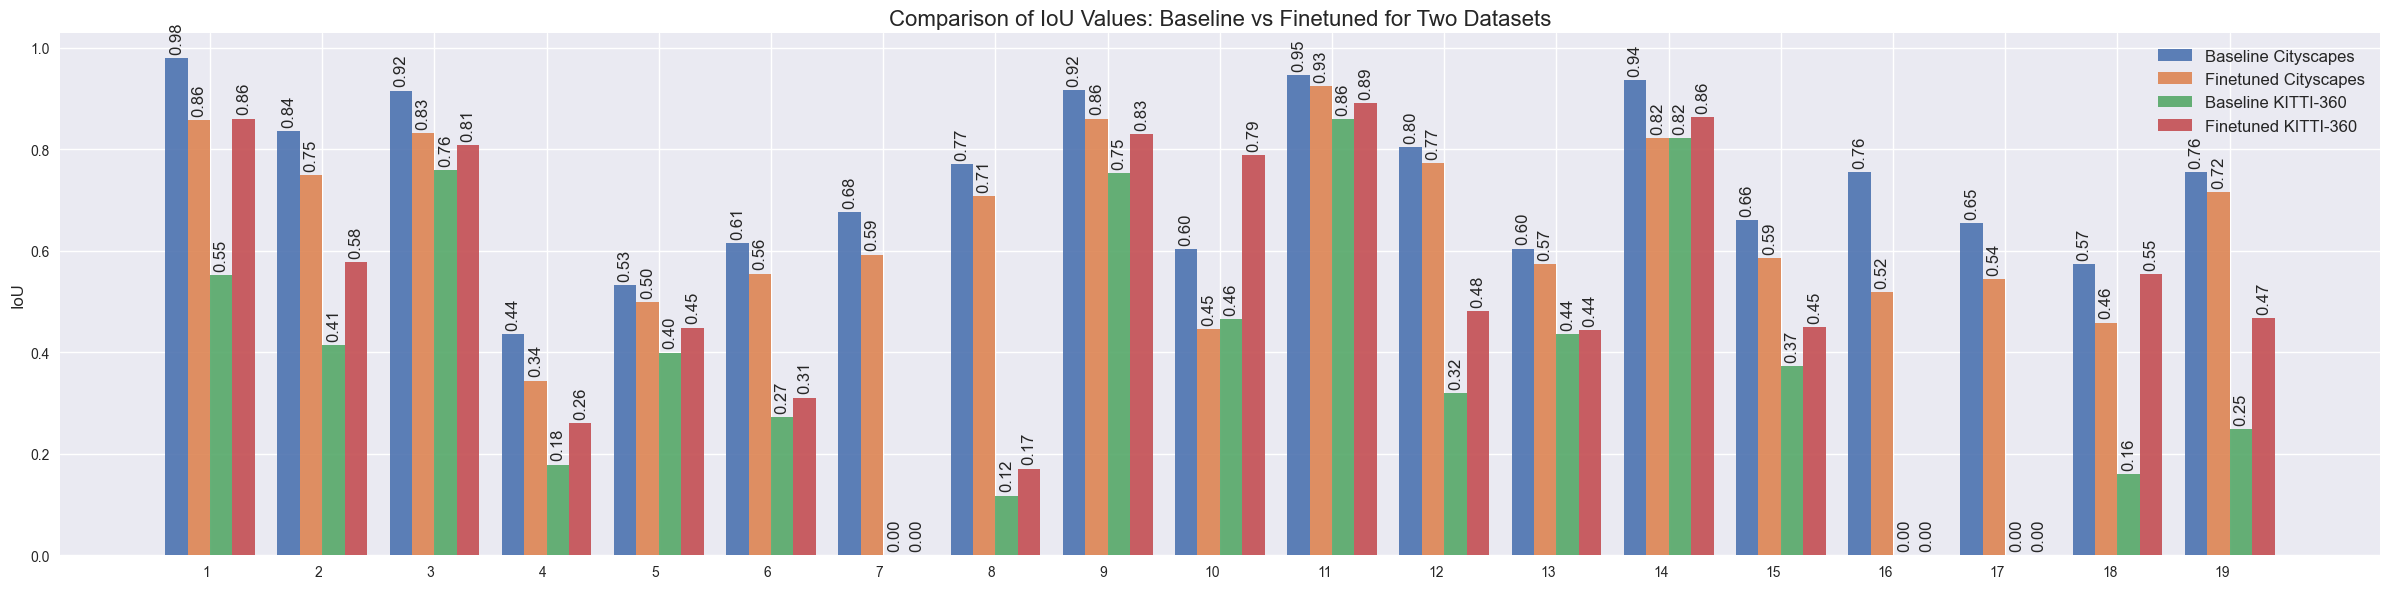

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined baseline_ious and finetuned_ious
# baseline_ious = np.array(baseline_ious)
# finetuned_ious = np.array(finetuned_ious)

# Set up the plot style
plt.style.use('seaborn')
sns.set_palette("deep")

# Create class labels (adjust as needed)
class_labels = [f'{i+1}' for i in range(19)]

# Set up the plot
fig, ax = plt.subplots(figsize=(24, 6))

# Set the width of each bar and the positions of the bars
width = 0.2
x = np.arange(len(class_labels))

# Create the bars
rects1 = ax.bar(x - 1.5 * width, baseline_ious[0], width, label='Baseline Cityscapes', alpha=0.9)
rects2 = ax.bar(x - 0.5 * width, finetuned_ious[0], width, label='Finetuned Cityscapes', alpha=0.9)
rects3 = ax.bar(x + 0.5 * width, baseline_ious[1], width, label='Baseline KITTI-360', alpha=0.9)
rects4 = ax.bar(x + 1.5 * width, finetuned_ious[1], width, label='Finetuned KITTI-360', alpha=0.9)

# Customize the plot
ax.set_ylabel('IoU', fontsize=12)
ax.set_title('Comparison of IoU Values: Baseline vs Finetuned for Two Datasets', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=0, ha='right')
ax.legend(fontsize=12)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

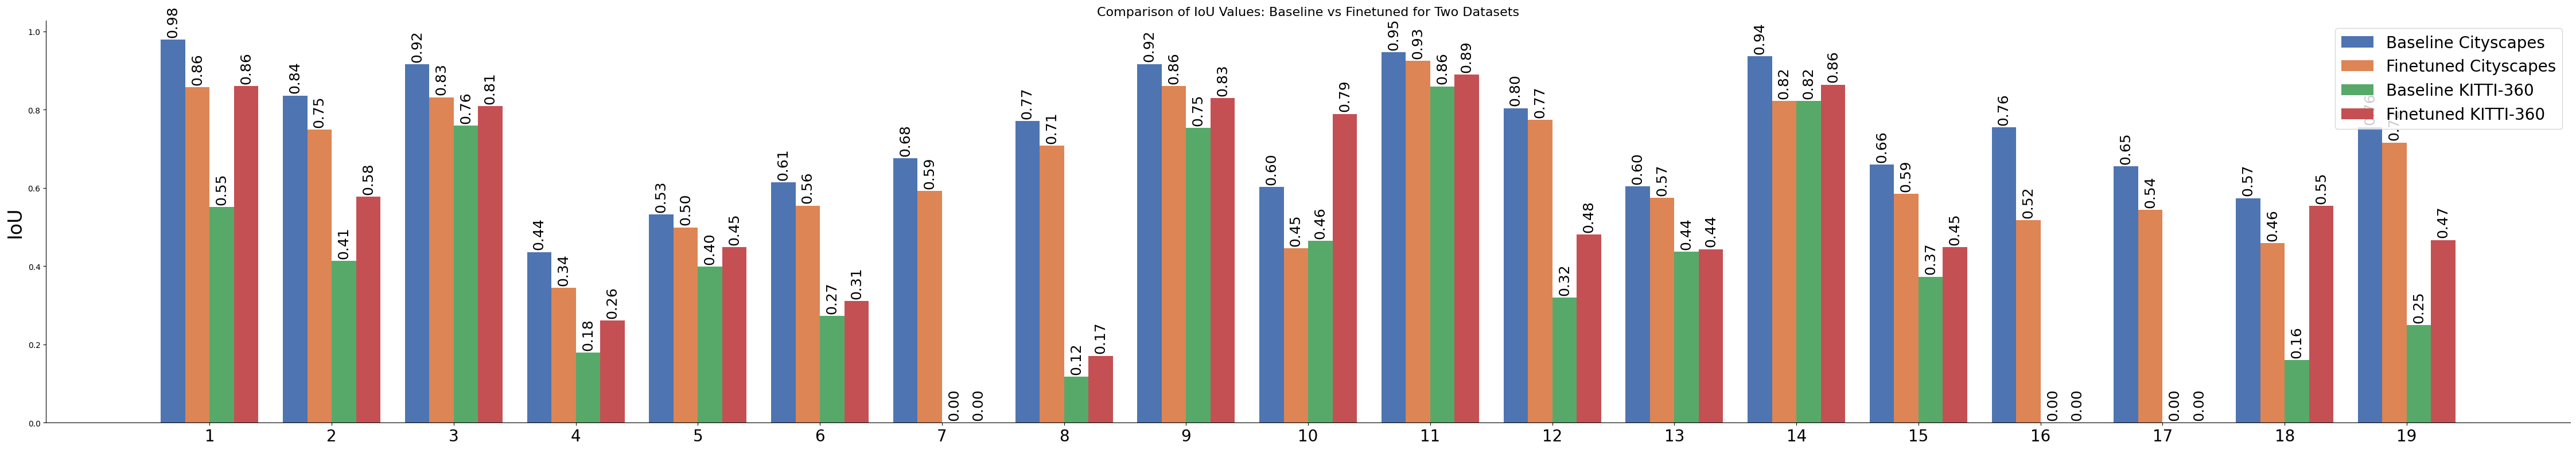

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
plt.style.use('default')  # Use default style instead of seaborn
sns.set_palette("deep")

# Create class labels (adjust as needed)
class_labels = [f'{i+1}' for i in range(19)]

# Set up the plot
fig, ax = plt.subplots(figsize=(45, 8))
fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')  # Set axes background to white

# Set the width of each bar and the positions of the bars
width = 0.2
x = np.arange(len(class_labels))

# Create the bars
rects1 = ax.bar(x - 1.5 * width, baseline_ious[0],  width, label='Baseline Cityscapes', alpha=0.99)
rects2 = ax.bar(x - 0.5 * width, finetuned_ious[0], width, label='Finetuned Cityscapes', alpha=0.99)
rects3 = ax.bar(x + 0.5 * width, baseline_ious[1], width, label='Baseline KITTI-360', alpha=0.99)
rects4 = ax.bar(x + 1.5 * width, finetuned_ious[1], width, label='Finetuned KITTI-360', alpha=0.99)

# Customize the plot
ax.set_ylabel('IoU', fontsize=24)
ax.set_title('Comparison of IoU Values: Baseline vs Finetuned for Two Datasets', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=0, ha='center', fontsize=20)
ax.legend(fontsize=20, loc='best')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=18, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

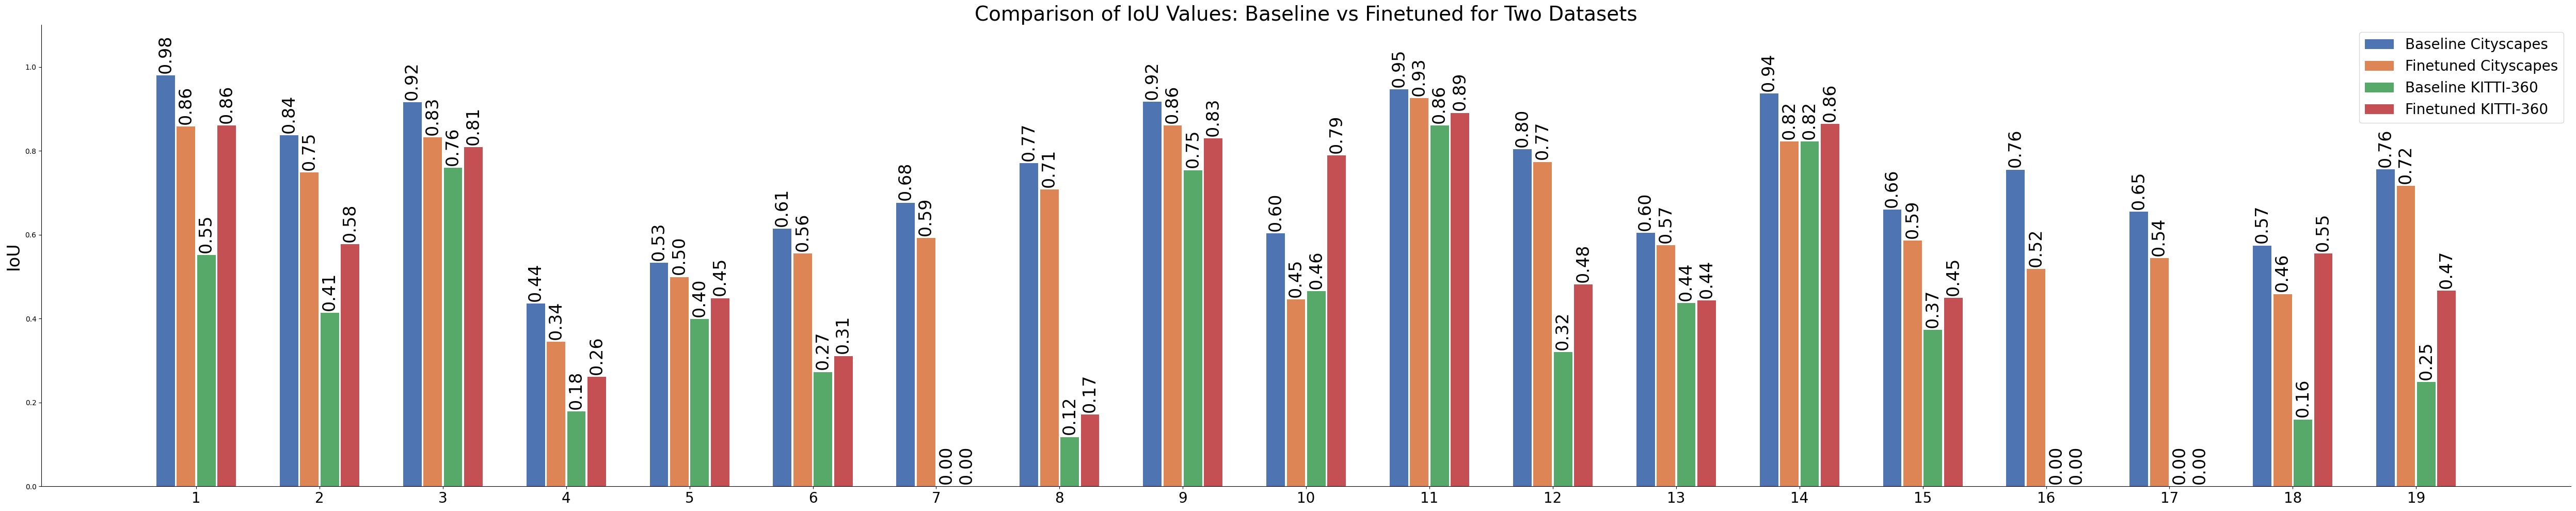

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
plt.style.use('default')
sns.set_palette("deep")

# Create class labels (adjust as needed)
class_labels = [f'{i+1}' for i in range(19)]

# Set up the plot
fig, ax = plt.subplots(figsize=(50, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set the width of each bar and the positions of the bars
width = 0.15  # Reduced width
x = np.arange(len(class_labels))

# Create the bars with adjusted positions
rects1 = ax.bar(x - 1.65 * width, baseline_ious[0], width, label='Baseline Cityscapes', alpha=0.99)
rects2 = ax.bar(x - 0.55 * width, finetuned_ious[0], width, label='Finetuned Cityscapes', alpha=0.99)
rects3 = ax.bar(x + 0.55 * width, baseline_ious[1], width, label='Baseline KITTI-360', alpha=0.99)
rects4 = ax.bar(x + 1.65 * width, finetuned_ious[1], width, label='Finetuned KITTI-360', alpha=0.99)

# Customize the plot
ax.set_ylabel('IoU', fontsize=24)
ax.set_title('Comparison of IoU Values: Baseline vs Finetuned for Two Datasets', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=0, ha='center', fontsize=20)

ax.legend(fontsize=20, loc='best')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=24, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Set y-axis limit to make bars appear smaller
ax.set_ylim(0, 1.1)  # Adjust the upper limit as needed

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

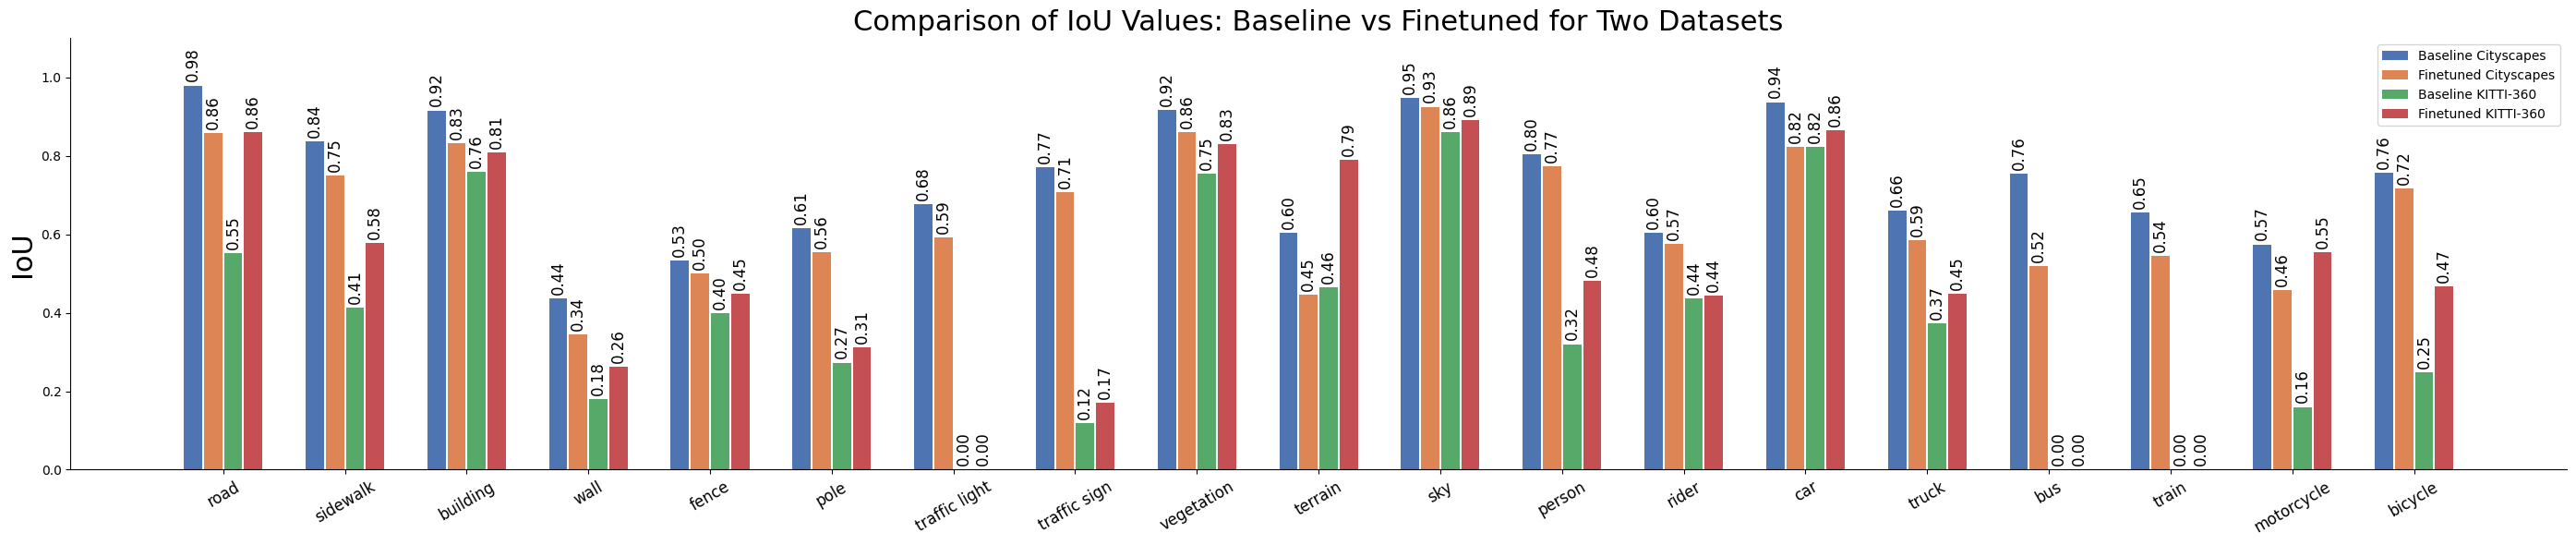

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
plt.style.use('default')
sns.set_palette("deep")

# Create class labels (adjust as needed)
class_labels = [f'{i+1}' for i in range(19)]

# Set up the plot with the specified size
fig, ax = plt.subplots(figsize=(28, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set the width of each bar and the positions of the bars
width = 0.15  # Reduced width
x = np.arange(len(class_labels))

# Create the bars with adjusted positions
rects1 = ax.bar(x - 1.65 * width, baseline_ious[0], width, label='Baseline Cityscapes', alpha=0.99)
rects2 = ax.bar(x - 0.55 * width, finetuned_ious[0], width, label='Finetuned Cityscapes', alpha=0.99)
rects3 = ax.bar(x + 0.55 * width, baseline_ious[1], width, label='Baseline KITTI-360', alpha=0.99)
rects4 = ax.bar(x + 1.65 * width, finetuned_ious[1], width, label='Finetuned KITTI-360', alpha=0.99)

# Customize the plot
ax.set_ylabel('IoU', fontsize=22)
ax.set_title('Comparison of IoU Values: Baseline vs Finetuned for Two Datasets', fontsize=22)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=30, ha='center', fontsize=12)

ax.legend(fontsize=10, loc='best')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Set y-axis limit to make bars appear smaller
ax.set_ylim(0, 1.1)  # Adjust the upper limit as needed

# Adjust layout
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('iou_comparison.png', dpi=400, bbox_inches='tight')

# Display the plot (optional, remove if you don't want to show it)
plt.show()

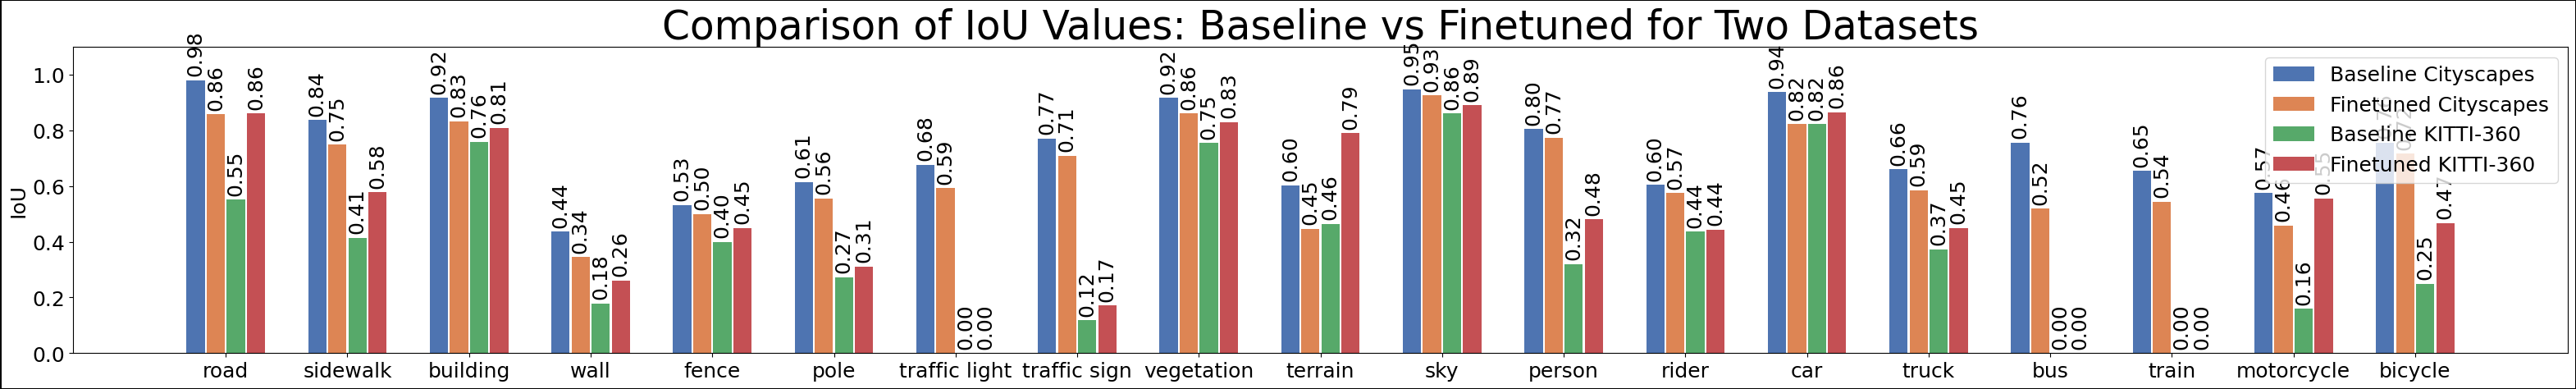

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
plt.style.use('default')
sns.set_palette("deep")

# Create class labels (adjust as needed)
class_labels = [f'{i+1}' for i in range(19)]

# Set up the plot with the specified size
fig, ax = plt.subplots(figsize=(31.5, 4.85))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set the width of each bar and the positions of the bars
width = 0.15  # Reduced width
x = np.arange(len(class_labels))

# Create the bars with adjusted positions
rects1 = ax.bar(x - 1.65 * width, baseline_ious[0], width, label='Baseline Cityscapes', alpha=0.99)
rects2 = ax.bar(x - 0.55 * width, finetuned_ious[0], width, label='Finetuned Cityscapes', alpha=0.99)
rects3 = ax.bar(x + 0.55 * width, baseline_ious[1], width, label='Baseline KITTI-360', alpha=0.99)
rects4 = ax.bar(x + 1.65 * width, finetuned_ious[1], width, label='Finetuned KITTI-360', alpha=0.99)

# Customize the plot
ax.set_ylabel('IoU', fontsize=18)
ax.set_title('Comparison of IoU Values: Baseline vs Finetuned for Two Datasets', fontsize=35)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=0, ha='center', fontsize=18)

# Increase the y-axis tick label size
ax.tick_params(axis='y', labelsize=18)

ax.legend(fontsize=18, loc='best')

# Make all spines visible
for spine in ax.spines.values():
    spine.set_visible(True)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=18, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Set y-axis limit to make bars appear smaller
ax.set_ylim(0, 1.1)  # Adjust the upper limit as needed

# Adjust layout
plt.tight_layout()

# Add a box around the entire figure
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(2)

# Save the plot as a high-resolution image
plt.savefig('iou_comparison.png', dpi=300, bbox_inches='tight', edgecolor='black')

# Display the plot (optional, remove if you don't want to show it)
plt.show()

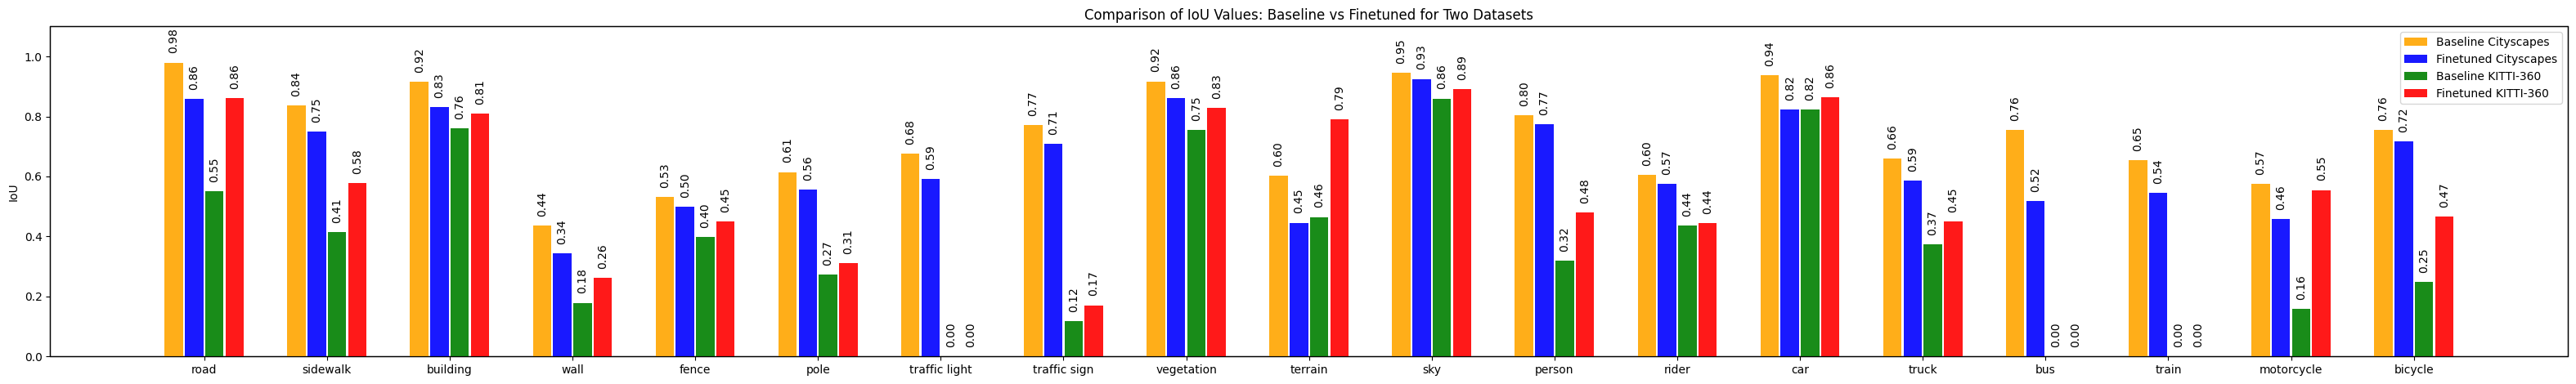

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
plt.style.use('default')
sns.set_palette("deep")

font = 10

# Create class labels (adjust as needed)
class_labels = [f'{i+1}' for i in range(19)]


# Set up the plot with the specified size
plt.figure(figsize=(31.6, 4.8))
plt.gca().patch.set_facecolor('white')

# Set the width of each bar and the positions of the bars
width = 0.15  # Reduced width
x = np.arange(len(class_labels))

# Create the bars with adjusted positions
rects1 = plt.bar(x - 1.65 * width, baseline_ious[0], width, label='Baseline Cityscapes', alpha=0.9, color='orange')
rects2 = plt.bar(x - 0.55 * width, finetuned_ious[0], width, label='Finetuned Cityscapes', alpha=0.9, color='blue')
rects3 = plt.bar(x + 0.55 * width, baseline_ious[1], width, label='Baseline KITTI-360', alpha=0.9, color='green')
rects4 = plt.bar(x + 1.65 * width, finetuned_ious[1], width, label='Finetuned KITTI-360', alpha=0.9, color='red')

# Customize the plot
plt.ylabel('IoU', fontsize=font)
plt.title('Comparison of IoU Values: Baseline vs Finetuned for Two Datasets', fontsize=font+2)
plt.xticks(x, class_names, rotation=0, ha='center', fontsize=font)

# Increase the y-axis tick label size
plt.yticks(fontsize=font)

plt.legend(fontsize=font, loc='best')

# Make all spines visible
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 8),  # 8 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=font, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Set y-axis limit to make bars appear smaller
plt.ylim(0, 1.1)  # Adjust the upper limit as needed

# Adjust layout
plt.tight_layout()

# Add a box around the entire figure
plt.gca().patch.set_edgecolor('black')
plt.gca().patch.set_linewidth(1)  # Increased linewidth

# Save the plot as a high-resolution image
plt.savefig('iou_comparison.png', dpi=300, bbox_inches='tight', edgecolor='black')

# # Save as PDF for lossless scaling
# plt.savefig('iou_comparison.pdf', format='pdf', bbox_inches='tight', edgecolor='black')

# # Save as SVG for lossless scaling
plt.savefig('iou_comparison.svg', format='svg', bbox_inches='tight', edgecolor='black')

# # Display the plot (optional, remove if you don't want to show it)
plt.show()

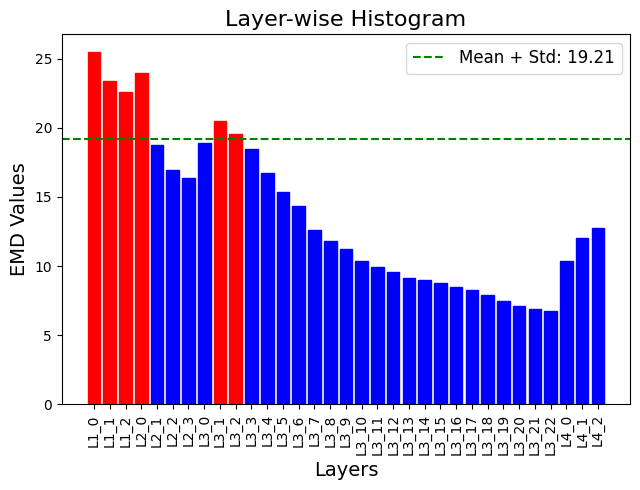

In [245]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    'L3_22': 6.771929789217945, 'L3_21': 6.870421296866964, 'L3_20': 7.148597402109317,
    'L3_19': 7.511650611130385, 'L3_18': 7.899454497349953, 'L3_17': 8.28148787102702,
    'L3_16': 8.515608109577371, 'L3_15': 8.7932655567523, 'L3_14': 8.9755200630274,
    'L3_13': 9.13987571755275, 'L3_12': 9.59898791425031, 'L3_11': 9.96700314518414,
    'L4_0': 10.357728089236016, 'L3_10': 10.405980109659335, 'L3_9': 11.202559541020364,
    'L3_8': 11.791000479451796, 'L4_1': 12.020775937537394, 'L3_7': 12.63856946234173,
    'L4_2': 12.76657478971032, 'L3_6': 14.335885048159254, 'L3_5': 15.365308952077728,
    'L2_3': 16.3909988616397, 'L3_4': 16.750407965391666, 'L2_2': 16.97602325021304,
    'L3_3': 18.433706463970267, 'L2_1': 18.74905778162617, 'L3_0': 18.903081081672525,
    'L3_2': 19.564767467790283, 'L3_1': 20.47213796386802, 'L1_2': 22.579378595713074,
    'L1_1': 23.394381646099333, 'L2_0': 23.972644050711285, 'L1_0': 25.48171130789431
}

# Calculate mean and standard deviation
values = list(data.values())
mean = np.mean(values)
std = np.std(values)
threshold = mean + std

# Sort the data by layer number and sub-number
sorted_data = sorted(data.items(), key=lambda x: (int(x[0].split('_')[0][1:]), int(x[0].split('_')[1])))

# Prepare data for plotting
layers = [item[0] for item in sorted_data]
values = [item[1] for item in sorted_data]

# Create the plot
plt.figure(figsize=(6.5, 5))
bars = plt.bar(layers, values)

# Color the bars
for i, bar in enumerate(bars):
    if values[i] >= threshold:
        bar.set_color('red')
    else:
        bar.set_color('blue')

# Customize the plot
plt.title('Layer-wise Histogram', fontsize=16)
plt.xlabel('Layers', fontsize=14)
plt.ylabel('EMD Values', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Add a horizontal line for mean + std
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Mean + Std: {threshold:.2f}')

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('layeyr_wise.png', dpi=450, bbox_inches='tight', edgecolor='black')
plt.savefig('layer_wise.svg', format='svg', bbox_inches='tight', edgecolor='black')
# Show the plot
plt.show()